In [1]:
import base64
import nltk
import numpy as np
import pandas as pd
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
from collections import Counter
from scipy.misc import imread
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from matplotlib import pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS

In [2]:
df = pd.read_csv('Combined_News_DJIA.csv')
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['text'] = df[df.columns[2:27]].apply(lambda x: ' '.join(x.astype(str)),axis=1)
train = df[df['Date'] < '2014-01-01']
test = df[df['Date'] > '2013-12-31']

In [3]:
df

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25,Year,text
0,2008-08-08,0,Georgia downs two Russian warplanes as count...,BREAKING: Musharraf to be impeached.,Russia Today: Columns of troops roll into Sout...,Russian tanks are moving towards the capital o...,"Afghan children raped with impunity, U.N. of...",150 Russian tanks have entered South Ossetia w...,"Breaking: Georgia invades South Ossetia, Russi...",The enemy combatent trials are nothing but a...,...,"Condoleezza Rice: ""The US would not act to pre...",This is a busy day: The European Union has ap...,"Georgia will withdraw 1,000 soldiers from Iraq...",Why the Pentagon Thinks Attacking Iran is a Ba...,Caucasus in crisis: Georgia invades South Osse...,Indian shoe manufactory - And again in a seri...,Visitors Suffering from Mental Illnesses Banne...,"No Help for Mexico s Kidnapping Surge""",2008,Georgia downs two Russian warplanes as count...
1,2008-11-08,1,Why wont America and Nato help us? If they won...,Bush puts foot down on Georgian conflict,Jewish Georgian minister: Thanks to Israeli tr...,Georgian army flees in disarray as Russians ad...,"Olympic opening ceremony fireworks faked """,What were the Mossad with fraudulent New Zeala...,Russia angered by Israeli military sale to Geo...,An American citizen living in S.Ossetia blames...,...,Riots are still going on in Montreal (Canada) ...,China to overtake US as largest manufacturer,War in South Ossetia [PICS],Israeli Physicians Group Condemns State Torture,Russia has just beaten the United States over...,Perhaps *the* question about the Georgia - Rus...,Russia is so much better at war,So this is what it s come to: trading sex for ...,2008,Why wont America and Nato help us? If they won...
2,2008-12-08,0,Remember that adorable 9-year-old who sang at ...,"Russia ends Georgia operation ""","""If we had no sexual harassment we would have ...",Al-Qa eda is losing support in Iraq because of...,Ceasefire in Georgia: Putin Outmaneuvers the W...,Why Microsoft and Intel tried to kill the XO $...,Stratfor: The Russo-Georgian War and the Balan...,I m Trying to Get a Sense of This Whole Georgi...,...,"Gorbachev accuses U.S. of making a ""serious bl...","Russia, Georgia, and NATO: Cold War Two",Remember that adorable 62-year-old who led you...,War in Georgia: The Israeli connection,All signs point to the US encouraging Georgia ...,Christopher King argues that the US and NATO a...,America: The New Mexico?,BBC NEWS | Asia-Pacific | Extinction by man n...,2008,Remember that adorable 9-year-old who sang at ...
3,2008-08-13,0,U.S. refuses Israel weapons to attack Iran: r...,When the president ordered to attack Tskhinval...,Israel clears troops who killed Reuters camer...,"Britain\ s policy of being tough on drugs is ""...",Body of 14 year old found in trunk; Latest (ra...,China has moved 10 *million* quake survivors i...,Bush announces Operation Get All Up In Russia ...,Russian forces sink Georgian ships,...,"Georgia s DDOS came from US sources""","Russian convoy heads into Georgia, violating t...",Israeli defence minister: US against strike on...,Gorbachev: We Had No Choice,Witness: Russian forces head towards Tbilisi i...,Quarter of Russians blame U.S. for conflict: ...,Georgian president says US military will take...,2006: Nobel laureate Aleksander Solzhenitsyn a...,2008,U.S. refuses Israel weapons to attack Iran: r...
4,2008-08-14,1,All the experts admit that we should legalise ...,War in South Osetia - 89 pictures made by a Ru...,Swedish wrestler Ara Abrahamian throws away me...,Russia exaggerated the death toll in South Oss...,Missile That Killed 9 Inside Pakistan May Have...,Rushdie Condemns Random House s Refusal to Pub...,Poland and US agree to missle defense deal. In...,"Will the Russians conquer Tblisi? Bet on it, n...",...,War in the Caucasus is as much the product of ...,"""Non-media"" photos of South Ossetia/Georgia co...",Georgian TV reporter shot by Russian sniper du...

In [4]:
trace1 = go.Bar(
    x=train.Year.unique(),
    y=train[train.Label==0][['Year', 'Label']].groupby(['Year']).count().values,
    name='DJIA value decreased',
    marker=dict(
        color='rgb(55, 83, 109)'
    )
)
trace2 = go.Bar(
    x=train.Year.unique(),
    y=train[train.Label==1][['Year', 'Label']].groupby(['Year']).count().values,
    name='DJIA value rose or stayed as the same',
    marker=dict(
        color='rgb(26, 118, 255)'
    )
)
data = [trace1, trace2]
layout = go.Layout(
    title='Behaviour of the Dow Jones Industrial Average (DJIA)',
    xaxis=dict(
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Frecuency it decrease or increase',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    legend=dict(
        x=1,
        y=1.0,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.15,
    bargroupgap=0.1
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='style-bar')

In [5]:
all_words = train['text'].str.split(expand=True).unstack().value_counts()
data = [go.Bar(
            x = all_words.index.values[2:50],
            y = all_words.values[2:50],
            marker= dict(colorscale='Jet',
                         color = all_words.values[2:100]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 (Uncleaned) Word frequencies in the training dataset'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

# Store each year news into a seperate variable depending of the DJIA

In [6]:
## For each year
DJIA_0_2008 = df[(df.Label==0)&(df.Year==2008)]["text"].values
DJIA_1_2008 = df[(df.Label==1)&(df.Year==2008)]["text"].values
DJIA_0_2009 = df[(df.Label==0)&(df.Year==2009)]["text"].values
DJIA_1_2009 = df[(df.Label==1)&(df.Year==2009)]["text"].values
DJIA_0_2010 = df[(df.Label==0)&(df.Year==2010)]["text"].values
DJIA_1_2010 = df[(df.Label==1)&(df.Year==2010)]["text"].values
DJIA_0_2011 = df[(df.Label==0)&(df.Year==2011)]["text"].values
DJIA_1_2011 = df[(df.Label==1)&(df.Year==2011)]["text"].values
DJIA_0_2012 = df[(df.Label==0)&(df.Year==2012)]["text"].values
DJIA_1_2012 = df[(df.Label==1)&(df.Year==2012)]["text"].values
DJIA_0_2013 = df[(df.Label==0)&(df.Year==2013)]["text"].values
DJIA_1_2013 = df[(df.Label==1)&(df.Year==2013)]["text"].values
DJIA_0_2014 = df[(df.Label==0)&(df.Year==2014)]["text"].values
DJIA_1_2014 = df[(df.Label==1)&(df.Year==2014)]["text"].values
DJIA_0_2015 = df[(df.Label==0)&(df.Year==2015)]["text"].values
DJIA_1_2015 = df[(df.Label==1)&(df.Year==2015)]["text"].values
DJIA_0_2016 = df[(df.Label==0)&(df.Year==2016)]["text"].values
DJIA_1_2016 = df[(df.Label==1)&(df.Year==2016)]["text"].values

# In general
DJIA_0 = train[train.Label==0]["text"].values
DJIA_1 = train[train.Label==1]["text"].values

(-0.5, 511.5, 511.5, -0.5)

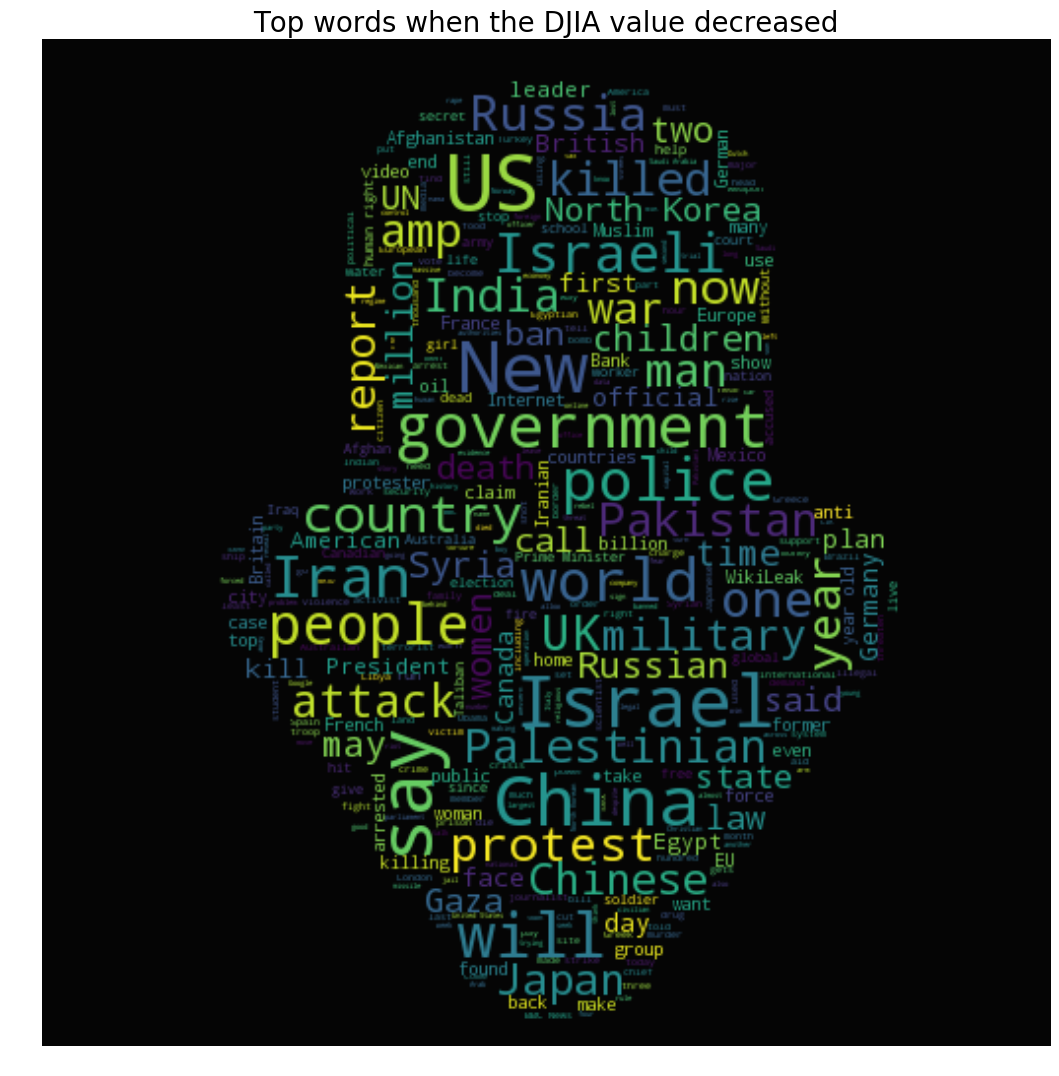

In [216]:
# The wordcloud of when the DJIA value decreased
img1 = imread("main_decrease.png")
plt.figure(figsize=(16,13))
wc = WordCloud(background_color = "black", max_words=10000,
               mask = img1, stopwords=STOPWORDS, max_font_size= 40)
wc.generate(" ".join(DJIA_0))
plt.title("Top words when the DJIA value decreased", fontsize=20)
plt.imshow(wc.recolor( colormap= 'viridis' , random_state=0), alpha=0.98)
plt.axis("off")


(-0.5, 246.5, 261.5, -0.5)

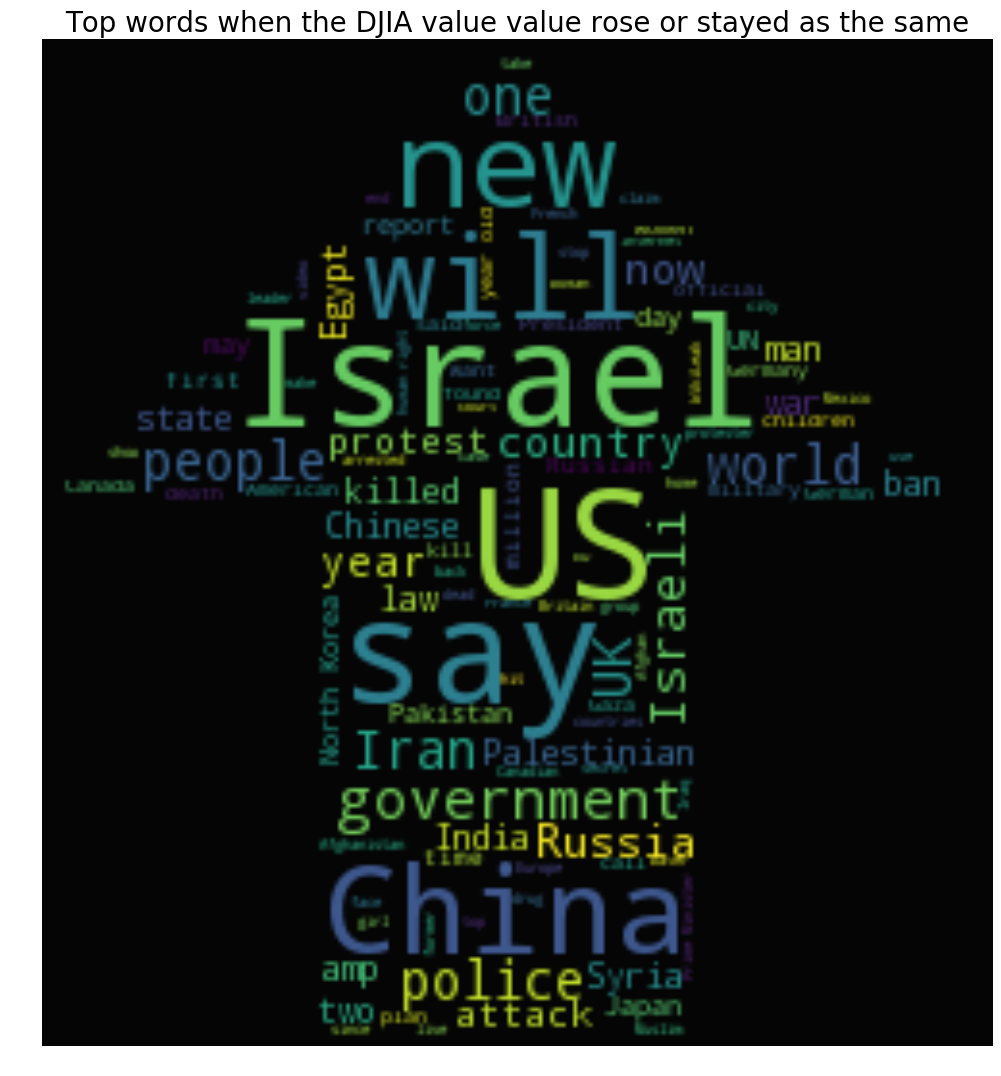

In [217]:
# The wordcloud of when the DJIA value value rose or stayed as the same
img1 = imread("main_increase.png")
plt.figure(figsize=(16,13))
wc = WordCloud(background_color = "black", max_words=10000,
               mask = img1, stopwords=STOPWORDS, max_font_size= 40)
wc.generate(" ".join(DJIA_1))
plt.title("Top words when the DJIA value value rose or stayed as the same", fontsize=20)
plt.imshow(wc.recolor( colormap= 'viridis' , random_state=0), alpha=0.98)
plt.axis("off")

## Tokenization

In [8]:
# Define helper function to print top words
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\nTopic #{}:".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)

In [9]:
lemm = WordNetLemmatizer()
class LemmaCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmaCountVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))

NameError: name 'WordNetLemmatizer' is not defined

In [220]:
# Storing the entire training text in a list
text = list(train.text.values)
# Calling our overwritten Count vectorizer
tf_vectorizer = LemmaCountVectorizer(max_df=0.95, 
                                     min_df=2,
                                     stop_words='english',
                                     decode_error='ignore')
tf = tf_vectorizer.fit_transform(text)

In [221]:
test_tf = tf_vectorizer.transform(test.text)

In [10]:
feature_names = tf_vectorizer.get_feature_names()
count_vec = np.asarray(tf.sum(axis=0)).ravel()
zipped = list(zip(feature_names, count_vec))
x, y = (list(x) for x in zip(*sorted(zipped, key=lambda x: x[1], reverse=True)))
# Now I want to extract out on the top 15 and bottom 15 words
Y = np.concatenate([y[0:15], y[-16:-1]])
X = np.concatenate([x[0:15], x[-16:-1]])

# Plotting the Plot.ly plot for the Top 50 word frequencies
data = [go.Bar(
            x = x[0:50],
            y = y[0:50],
            marker= dict(colorscale='Jet',
                         color = y[0:50]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 Word frequencies after Preprocessing'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')


NameError: name 'tf_vectorizer' is not defined

In [223]:
# Plotting the Plot.ly plot for Bottom 100 Word frequencies
data = [go.Bar(
            x = x[-100:],
            y = y[-100:],
            marker= dict(colorscale='Portland',
                         color = y[-100:]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Bottom 100 Word frequencies after Preprocessing'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

In [224]:
from sklearn import feature_extraction, linear_model, ensemble, model_selection, metrics, decomposition
model = linear_model.LogisticRegression()

In [225]:
model_selection.cross_val_score(model, tf, train.Label, cv = 5).mean()

0.48711742999782948

In [226]:
train_Label_hat = model_selection.cross_val_predict(model, tf, train.Label, cv = 5)

metrics.accuracy_score(train.Label, train_Label_hat)

0.48712288447387786

In [227]:
pd.crosstab(train_Label_hat, train.Label, rownames = ['Hypothesized Class'], colnames = ['True Class'])

True Class,0,1
Hypothesized Class,,
0,266,338
1,359,396


In [228]:
model.fit(tf, train.Label)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [229]:
model.score(tf, train.Label)

1.0

In [231]:
prediction = model.predict(test_tf)

In [232]:
pd.crosstab(prediction, test.Label, rownames = ['Hypothesized Class'], colnames = ['True Class'])

True Class,0,1
Hypothesized Class,,
0,124,142
1,175,189


In [233]:
model.score(test_tf, test.Label)

0.49682539682539684